# How to Test Relational Fusion Network and Basline Algorithms

In [1]:
%load_ext autoreload
%autoreload 2

### Test
First, define test city sets.

In [2]:
# train_cities = ["busan", "daejeon", "goyang", "gwangju", "incheon", "changwon", "seongnam", "cheongju"]
test_cities = ["daegu", "suwon", "ulsan", "yongin"]

Then define models to test. We used 4 RFN vaiations and 4 baseline models(GAT, GCB, GraphSAGE and MLP).

In [3]:
# from custom.rfn_trainer import RFNTrainer
# from custom.gcn_trainer import GCNTrainer
# from custom.mlp_trainer import MLPTrainer
# from custom.utils import * 

# # RFN models
# rfn_trainer_ia = RFNTrainer(fusion='interactional', aggregator='attentional')
# rfn_trainer_in = RFNTrainer(fusion='interactional', aggregator='non-attentional')
# rfn_trainer_aa = RFNTrainer(fusion='additive', aggregator='attentional')
# rfn_trainer_an = RFNTrainer(fusion='additive', aggregator='non-attentional')

# # Baseline models
# gcn_trainer_gat = GCNTrainer("gat")
# gcn_trainer_gcn = GCNTrainer("gcn")
# gcn_trainer_gsg = GCNTrainer("graphsage")
# mlp_trainer = MLPTrainer()


# rfn_models = [rfn_trainer_ia, rfn_trainer_in, rfn_trainer_aa, rfn_trainer_an]
# baseline_models = [gcn_trainer_gat, gcn_trainer_gcn, gcn_trainer_gsg, mlp_trainer]
# target_models = rfn_models + baseline_models

In [8]:
import osmnx as ox
G =ox.load_graphml('data/suwon_drive_network_original.graphml')
G = ox.add_edge_speeds(G)

In [19]:
nodes, edges=ox.graph_to_gdfs(G, nodes=True)


In [20]:
print(edges.keys())

Index(['osmid', 'name', 'highway', 'oneway', 'length', 'speed_kph', 'geometry',
       'maxspeed', 'ref', 'lanes', 'tunnel', 'bridge', 'access', 'junction',
       'service', 'u', 'v', 'key'],
      dtype='object')


In [22]:
print(edges['name'])

0        인계로220번길
1        인계로220번길
2        인계로220번길
3             서부로
4             인계로
           ...   
21249     권광로92번길
21250         효원로
21251         향교로
21252         효원로
21253         향교로
Name: name, Length: 21254, dtype: object


In [ ]:
G_sub = 

In [16]:
def f(k):
    r = hash(str(k['speed_kph']))% 256
    g = hash(str(k['speed_kph'])+'tas')% 256
    b = hash(str(k['speed_kph'])+'aan')% 256
    r /= 255
    g /= 255
    b /= 255
    
    return (r, g, b)

In [17]:
ec = [f(info) for u, v, info in G.edges(data=True)]

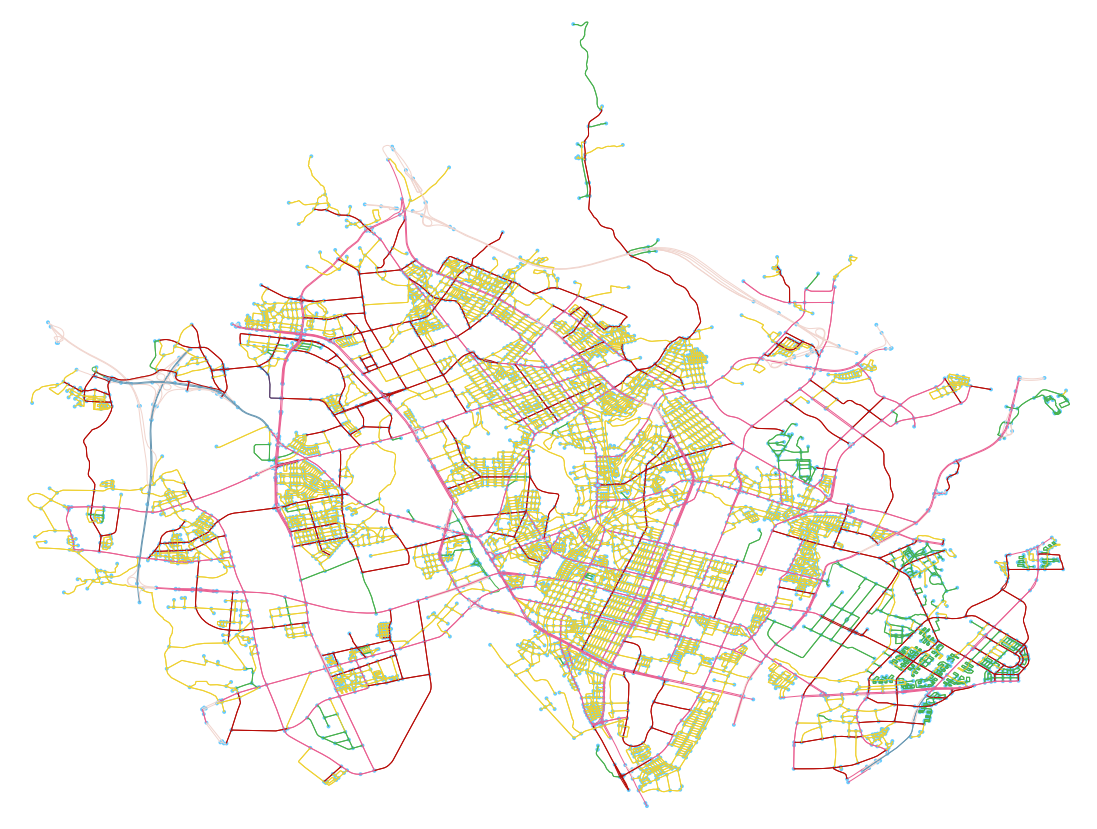

(<Figure size 1397.44x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f810a096750>)

In [18]:
ox.plot_graph(G, edge_color = ec, fig_height=15)

Add city information to trainer. Note that MXNet is used for RFN while dgl+PyTorch is used for the rest.

In [4]:
for city_name in test_cities:
    G = load_city_graph(city_name)
    rfn_city, dgl_city = generate_required_city_graph(city_name, G)
    for t in target_models:
        if isinstance(t, RFNTrainer):
            t.add_city(rfn_city, train=False)
        else:
            t.add_city(dgl_city, train=False)

[41134, 35295, 53753, 34446]
Primal V,E: (18339, 52910), Dual V,E: (52910, 164628)
[17056, 14445, 21915, 14132]
Primal V,E: (7162, 21254), Dual V,E: (21254, 67548)
[20713, 17365, 27460, 17380]
Primal V,E: (8822, 26070), Dual V,E: (26070, 82918)
[11159, 7614, 15077, 7594]
Primal V,E: (5659, 14447), Dual V,E: (14447, 41444)


Now build network and load data.

In [5]:
load_data_folder = 'model_data/20200619_182329'
for t in target_models:
    t.build()
    t.load_params("%s/%s" % (load_data_folder, t.name))

FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)
FeatureInfo(no_node_features=2, no_edge_features=16, no_between_edge_features=4)


Test on each road networks.

In [6]:
test_results = {}
for t in target_models:
    test_results[t.name] = t.test()

Loss at City daegu 0.013797159
Loss at City suwon 0.0064674113
Loss at City ulsan 0.017538503
Loss at City yongin 0.008208394
Loss at City daegu 0.017246969
Loss at City suwon 0.01251529
Loss at City ulsan 0.019019421
Loss at City yongin 0.02812277
Loss at City daegu 0.01597777
Loss at City suwon 0.010970065
Loss at City ulsan 0.019676274
Loss at City yongin 0.028278925
Loss at City daegu 0.01581756
Loss at City suwon 0.010133996
Loss at City ulsan 0.019537376
Loss at City yongin 0.02983389


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 7.79 GiB total capacity; 353.55 MiB already allocated; 14.31 MiB free; 386.00 MiB reserved in total by PyTorch)

Now print results.

In [ ]:
a = pd.DataFrame.from_dict(test_results)
print(a.transpose())

## References
[1]: Tobias Skovgaard Jepsen, Christian S. Jensen, and Thomas Dyhre Nielsen.  "Graph Convolutional Networks for Road Networks." In _27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (SIGSPATIAL ’19)_. 2019.

[2]: Tobias Skovgaard Jepsen, Christian S. Jensen, and Thomas Dyhre Nielsen. "Graph Convolutional Networks for Road Networks." _arXiv e-prints_, arXiv:1908.11567. 2019.

[3]: Hamilton, Will, Zhitao Ying, and Jure Leskovec. "Inductive representation learning on large graphs." _Advances in Neural Information Processing Systems_. 2017.